# Introduction

In the following notebook, I will be modeling Airbnb Listings data to create a price predictor to using a Deep Learning model

**Read in libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import tensorflow as tf
from tensorflow import keras

C:\Users\kishe\AppData\Roaming\Python\Python37\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Set notebook preferences**

In [2]:
#Set options for pandas
pd.set_option('display.max_columns',1_000)
pd.set_option('display.max_rows',500)
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

#Set options for numpy
np.set_printoptions(suppress=True)

#Set visualization preferences
plt.style.use('Solarize_Light2')

#Surpress warnings
import warnings
warnings.simplefilter('ignore')

#Set path to training data
path = r'C:\Users\kishe\Documents\Data Science\Projects\Python Projects\In Progress\Airbnb - San Francisco Listings Analysis\Data\03_Processed'

#Set path to write visuals
viz_path = r'C:\Users\kishe\Documents\Data Science\Projects\Python Projects\In Progress\Airbnb - San Francisco Listings Analysis\Visualizations\Modeling'

**Read in data**

In [3]:
#Read data
df = pd.read_csv(path + '/2020_0715_Listings_Processed.csv', index_col=0)

**Preview Data**

In [4]:
#Preview data
print('Data shape:',df.shape)
display(df.head())

Data shape: (116180, 40)


,accommodates,amenities_count,availability_30,availability_365,availability_60,availability_90,bathrooms,bed_type,bedrooms,beds,cleaning_fee,extra_people,guests_included,holiday,host_has_profile_pic,host_identity_verified,host_is_superhost,host_response_rate,host_response_time,instant_bookable,is_location_exact,last_review_month_encoded,last_review_weekday_encoded,last_review_year_encoded,latitude,longitude,maximum_nights,minimum_nights,neighbourhood_cleansed_encoded,number_of_reviews,price,property_type,require_guest_phone_verification,require_guest_profile_picture,requires_license,review_scores_rating,reviews_per_month,room_type,security_deposit,weekend
0,3,26,0,77,0,1,1.000,Real Bed,1.000,2.000,100.000,25.000,2,False,1.000,1.000,1.000,100.000,within an hour,1,1,198.408,202.011,211.675,37.769,-122.434,30,1,253.859,183,170.000,Apartment,0,0,1,97.000,1.550,Entire home/apt,100.000,True
1,2,16,30,365,60,90,4.000,Real Bed,1.000,1.000,50.000,12.000,1,False,1.000,1.000,0.000,100.000,within a few hours,0,1,207.744,207.177,214.232,37.765,-122.452,90,32,209.222,8,65.000,Apartment,0,0,1,93.000,0.140,Private room,200.000,False
3,6,33,0,20,5,9,1.000,Real Bed,2.000,3.000,125.000,0.000,1,False,1.000,0.000,0.000,90.000,within a day,0,1,198.408,202.011,211.675,37.785,-122.446,365,2,253.859,32,255.000,Apartment,0,0,1,90.000,0.270,Entire home/apt,0.000,True
4,3,34,4,131,19,42,1.000,Real Bed,1.000,2.000,50.000,60.000,2,False,1.000,0.000,1.000,100.000,within an hour,1,1,198.408,202.011,211.675,37.759,-122.422,14,1,215.286,656,139.000,Condominium,0,0,1,98.000,5.570,Private room,0.000,True
5,2,23,14,311,21,44,1.000,Real Bed,1.000,1.000,50.000,0.000,1,False,1.000,1.000,0.000,100.000,within an hour,0,1,198.408,235.135,211.675,37.763,-122.405,365,1,238.334,457,135.000,House,0,0,1,94.000,3.980,Private room,2.000,False


# Model Development

### Prepare Data

**Split data into X and y**

In [5]:
#Split data into X and y
X = df.drop('price', axis = 1)
y = df.price.values

**One-Hot Encode**

In [6]:
#Read in Libraries
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

#Subset categorical variables
cat_features = X.select_dtypes('object').columns

#Init ColumnTransformer 
ct = ColumnTransformer([('onehot', OneHotEncoder(handle_unknown='ignore'), cat_features)],remainder='passthrough')

#One-hot encode categorical variables'
X_encoded = ct.fit_transform(X)

**Split data and scale**

In [7]:
#Import libraries
from sklearn.model_selection import train_test_split

#Split data
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, 
                                                    test_size = .2,
                                                   random_state = 24)

#Check
print('Training data:{} | Training labels:{}'.format(X_train.shape,y_train.shape))
print('Test data:{} | Test labels:{}'.format(X_test.shape,y_test.shape))

Training data:(92944, 79) | Training labels:(92944,)
Test data:(23236, 79) | Test labels:(23236,)


In [8]:
#Init scaler
scaler = StandardScaler()

#Fit and transform training and test data
X_train_transformed = scaler.fit_transform(X_train)
X_test_transformed = scaler.transform(X_test)

In [9]:
X_train_transformed.shape

(92944, 79)

## Base model

**Build and compile**

In [15]:
tf.keras.backend.clear_session()

#Init base model
base_model = tf.keras.models.Sequential()

#Add Layers
base_model.add(tf.keras.layers.Dense(units = X_train_transformed.shape[1], activation = 'relu', input_shape = (X_train_transformed.shape[1],)))
base_model.add(tf.keras.layers.Dense(units = 64, activation = 'relu'))
base_model.add(tf.keras.layers.Dense(units = 1))

#compile
base_model.compile(loss = 'mean_squared_error', optimizer = 'Adam',)

**Train Base Model**

In [16]:
#Train model
history = base_model.fit(X_train_transformed,y_train, validation_split=.2, batch_size= 100, epochs=100, shuffle=True)

Epoch 1/100
744/744 [==============================] - 1s 1ms/step - loss: 6491.1758 - val_loss: 2920.2222
Epoch 2/100
744/744 [==============================] - 1s 1ms/step - loss: 2708.2395 - val_loss: 2737.3188
Epoch 3/100
744/744 [==============================] - 1s 1ms/step - loss: 2581.5654 - val_loss: 2653.1541
Epoch 4/100
744/744 [==============================] - 1s 1ms/step - loss: 2494.1350 - val_loss: 2570.3777
Epoch 5/100
744/744 [==============================] - 1s 1ms/step - loss: 2412.2993 - val_loss: 2514.1997
Epoch 6/100
744/744 [==============================] - 1s 1ms/step - loss: 2334.1960 - val_loss: 2496.5869
Epoch 7/100
744/744 [==============================] - 1s 1ms/step - loss: 2261.8687 - val_loss: 2481.9792
Epoch 8/100
744/744 [==============================] - 1s 1ms/step - loss: 2191.2383 - val_loss: 2569.5059
Epoch 9/100
744/744 [==============================] - 1s 1ms/step - loss: 2135.9324 - val_loss: 2666.8018
Epoch 10/100
744/744 [===============

**Evaluate Training Loss**

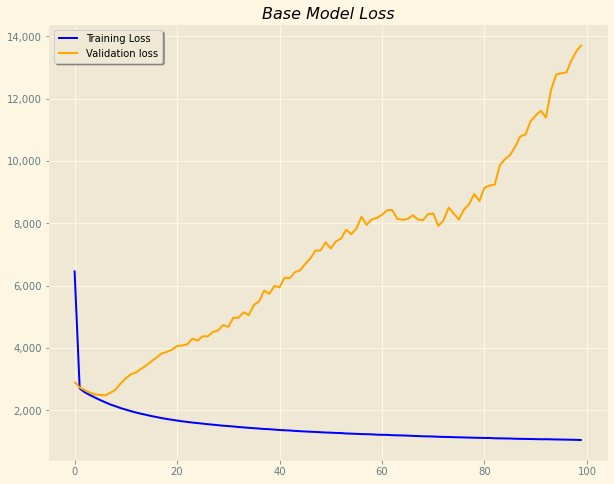

In [17]:
#Store training loss as a data frame
training_loss = pd.DataFrame()
training_loss['loss'] = history.history['loss']
training_loss['val_loss'] = history.history['val_loss']

#Create figure
f, ax = plt.subplots(figsize = (10,8))

#Plot training loss
training_loss.plot(ax=ax, color = ['blue', 'orange'])

#Set plot aesthetics
ax.set_title('Base Model Loss', fontstyle = 'italic')
ax.legend(['Training Loss', 'Validation loss'], frameon = True, shadow = True)
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

#Save figure
plt.savefig(viz_path + '/Base_Model_Loss.png',bbox_inches='tight')

**Save/Load Trained Base Model**

In [18]:
#Set path to save/load trained model
path = r'C:\Users\kishe\Documents\Data Science\Projects\Python Projects\In Progress\Airbnb - San Francisco Listings Analysis\Project_Codes\04_Modeling\Saved_Models'

#Save Trained model
tf.keras.models.save_model(model = base_model, filepath = path + '/Base_ANN_Regressor')

# #Load saved model
# base_model = tf.keras.models.load_model(filepath = path + '/Base_ANN_Regressor')

#Print model summary
print('Base ANN Summary:\n', base_model.summary())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: C:\Users\kishe\Documents\Data Science\Projects\Python Projects\In Progress\Airbnb - San Francisco Listings Analysis\Project_Codes\04_Modeling\Saved_Models/Base_ANN_Regressor\assets
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 79)                6320      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                5120      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 11,505
Trainable params: 11,505
Non-trainable params: 0
_________________________________________________________________
Base ANN Summary:
 None


**Evaluate base model on test data**

In [19]:
#Read in regression metrics
from Regression_Metrics import regression_metrics

#Evaluate performance on test data
predictions = base_model.predict(X_test_transformed,batch_size=100)

#Store predictions, actual, and error
base_results = pd.DataFrame(predictions, columns=['predictions'])
base_results['actual']=y_test
base_results['error'] = base_results['predictions'] - base_results['actual']

Base Model Evaluation Metrics:
R2: 0.8346643313731155
MAE: 25.344763116472087 
MSE: 14273.21742689797
RMSE: 119.47057138432866


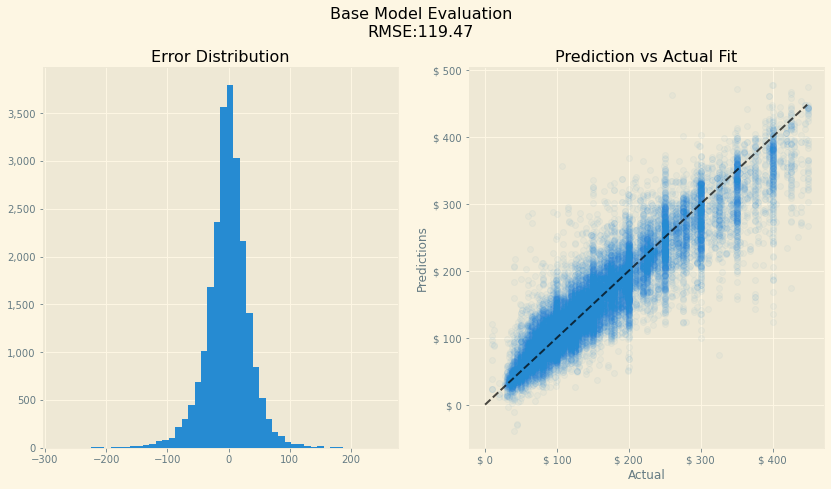

In [20]:
#View results
metrics = regression_metrics('Base Model', predictions, y_test)

#Create figure
f, ax = plt.subplots(1,2,figsize = (14,7))

#Plot error distribution
base_results.error.hist(ax = ax[0], bins = 50)

#PLot Predictions against Actual
ax[1].scatter(x = base_results.actual, y = base_results.predictions, alpha = .04)

#PLot best fit line
X=list(np.arange(0,max(base_results.actual)))
ax[1].plot(X,X, color = 'black', linestyle = '--', alpha = .7)

#Set plot aesthetics
plt.suptitle('Base Model Evaluation\nRMSE:{}'.format(round(metrics['rmse'],2)), y =1.0, fontsize = 16)
ax[0].set_title('Error Distribution')
ax[0].get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

ax[1].set_title('Prediction vs Actual Fit')
ax[1].set_xlabel('Actual')
ax[1].get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "$ {:}".format(int(x))))
ax[1].set_ylabel('Predictions')
ax[1].get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "$ {:}".format(int(x))))

#Save figure
plt.savefig(viz_path + '/Base_Model_Error_Evaluation.png',bbox_inches='tight')

## ANN Model V1

**Build Model**

Initial model was underfitting. We'll add layers to our next iteration of the model and also increase the number of epochs to 300

In [21]:
#Rest Session
tf.keras.backend.clear_session()

#Init base model
model_v1 = tf.keras.models.Sequential()

#Add Layers
model_v1.add(tf.keras.layers.Dense(units = X_train_transformed.shape[1], activation = 'relu',input_shape=(X_train_transformed.shape[1],)))
model_v1.add(tf.keras.layers.Dropout(.2))

model_v1.add(tf.keras.layers.Dense(units = 128, activation = 'relu'))
model_v1.add(tf.keras.layers.Dropout(.2))

model_v1.add(tf.keras.layers.Dense(units = 128, activation = 'relu'))
model_v1.add(tf.keras.layers.Dropout(.2))

model_v1.add(tf.keras.layers.Dense(units = 64, activation = 'relu'))
model_v1.add(tf.keras.layers.Dropout(.2))

model_v1.add(tf.keras.layers.Dense(units = 1, activation = 'relu'))

#compile
model_v1.compile(loss = 'mean_squared_error', optimizer = 'Adam',)

**Train model_v1**

In [22]:
history = model_v1.fit(X_train_transformed, y_train,epochs=300, validation_split=.2, shuffle=True, batch_size = 100)

Epoch 1/300
744/744 [==============================] - 2s 3ms/step - loss: 5116.1245 - val_loss: 2976.1807
Epoch 2/300
744/744 [==============================] - 2s 3ms/step - loss: 3252.6414 - val_loss: 2626.7188
Epoch 3/300
744/744 [==============================] - 2s 3ms/step - loss: 3040.0916 - val_loss: 2587.4546
Epoch 4/300
744/744 [==============================] - 2s 3ms/step - loss: 2982.8647 - val_loss: 2471.1934
Epoch 5/300
744/744 [==============================] - 2s 3ms/step - loss: 2883.8347 - val_loss: 2519.4133
Epoch 6/300
744/744 [==============================] - 2s 3ms/step - loss: 2819.5486 - val_loss: 2584.8042
Epoch 7/300
744/744 [==============================] - 2s 3ms/step - loss: 2725.2668 - val_loss: 2362.3774
Epoch 8/300
744/744 [==============================] - 2s 3ms/step - loss: 2722.8450 - val_loss: 2412.4607
Epoch 9/300
744/744 [==============================] - 2s 3ms/step - loss: 2673.8523 - val_loss: 2523.8245
Epoch 10/300
744/744 [===============

**Evaluate Training Loss**

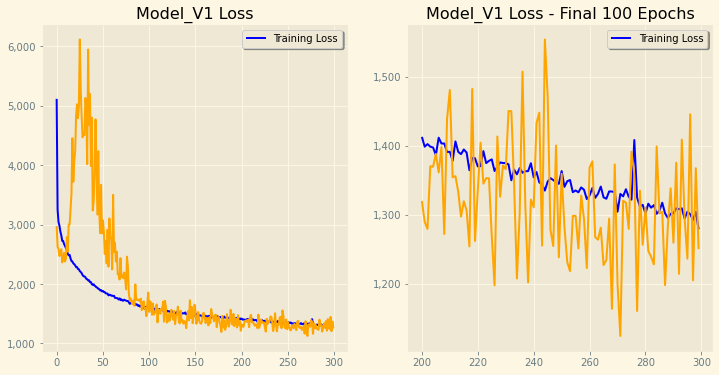

In [23]:
#Store training loss 
training_loss = pd.DataFrame()
training_loss['loss'] = history.history['loss']
training_loss['val_loss'] = history.history['val_loss']

#Create figure
f, ax = plt.subplots(1,2,figsize = (12,6))

#Plot training loss
training_loss.plot(ax=ax[0], color = ['blue','orange'])
training_loss[200:300].plot(ax=ax[1], color = ['blue','orange'])

#Set plot aesthetics
ax[0].set_title('Model_V1 Loss')
ax[0].legend(['Training Loss'], frameon = True, shadow = True)
ax[0].get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

#Set plot aesthetics
ax[1].set_title('Model_V1 Loss - Final 100 Epochs')
ax[1].legend(['Training Loss'], frameon = True, shadow = True)
ax[1].get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

#Save figure
#plt.savefig(viz_path + '/Model_V1.png',bbox_inches='tight')

**Save/Load Trained Base Model**

In [24]:
#Set path to save/load trained model
path = r'C:\Users\kishe\Documents\Data Science\Projects\Python Projects\In Progress\Airbnb - San Francisco Listings Analysis\Project_Codes\04_Modeling\Saved_Models'

#Save Trained model
tf.keras.models.save_model(model = model_v1, filepath = path + '/ANN_V1_Regressor')

# #Load saved model
# model_v1 = tf.keras.models.load_model(filepath = path + '/ANN_V1_Regressor')

#Print model summary
print('V1 ANN Summary:\n', model_v1.summary())

INFO:tensorflow:Assets written to: C:\Users\kishe\Documents\Data Science\Projects\Python Projects\In Progress\Airbnb - San Francisco Listings Analysis\Project_Codes\04_Modeling\Saved_Models/Base_ANN_Regressor\assets
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 79)                6320      
_________________________________________________________________
dropout (Dropout)            (None, 79)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               10240     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
______________________________________

**Evaluate base model on test data**

In [25]:
#Get predictions
v1_predictions = model_v1.predict(X_test_transformed, batch_size = 100)

In [26]:
#Store predictions, actual, and error
v1_results = pd.DataFrame(v1_predictions, columns=['predictions'])
v1_results['actual']=y_test
v1_results['error'] = v1_results['predictions'] - v1_results['actual']

#Evaluate Results
v1_metrics = regression_metrics('ANN Model V1', v1_predictions, y_test)

ANN Model V1 Evaluation Metrics:
R2: 0.8372342370727042
MAE: 25.30789732017786 
MSE: 12097.177294244178
RMSE: 109.98716877092609


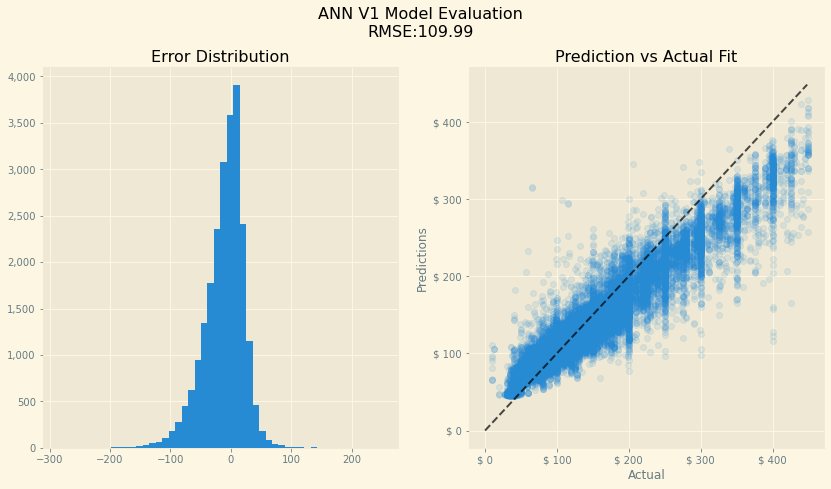

In [27]:
#Create figure
f, ax = plt.subplots(1,2,figsize = (14,7))

#Plot error distribution
v1_results.error.hist(ax = ax[0], bins = 50)

#PLot Predictions against Actual
ax[1].scatter(x = v1_results.actual, y = v1_results.predictions, alpha = .1)

#PLot best fit line
X=list(np.arange(0,max(v1_results.actual)))
ax[1].plot(X,X, color = 'black', linestyle = '--', alpha = .7)

#Set plot aesthetics
plt.suptitle('ANN V1 Model Evaluation\nRMSE:{}'.format(round(v1_metrics['rmse'],2)), y =1.0, fontsize = 16)
ax[0].set_title('Error Distribution')
ax[0].get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

ax[1].set_title('Prediction vs Actual Fit')
ax[1].set_xlabel('Actual')
ax[1].get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "$ {:}".format(int(x))))
ax[1].set_ylabel('Predictions')
ax[1].get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "$ {:}".format(int(x))))

#Save figure
plt.savefig(viz_path + '/ANNV1_Error_Evaluation.png',bbox_inches='tight')

## ANN Model V2

**Build Model**

We'll increase the number of epochs and add one more layer

In [85]:
#Rest Session
tf.keras.backend.clear_session()

tf.keras.optimizers.Adam(
    learning_rate=0.005, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam', 
)

class LearningRateReducerCb(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        old_lr = self.model.optimizer.lr.read_value() 
        new_lr = old_lr * 1.001
        print("\nEpoch: {}. Reducing Learning Rate from {} to {}".format(epoch, old_lr, new_lr))
        self.model.optimizer.lr.assign(new_lr)
#Init base model
model_v2 = tf.keras.models.Sequential()

#Add Layers
model_v2.add(tf.keras.layers.Dense(units = X_train_transformed.shape[1], activation = 'relu',input_shape=(X_train_transformed.shape[1],)))
model_v2.add(tf.keras.layers.Dropout(.2))

model_v2.add(tf.keras.layers.Dense(units = 64, activation = 'relu'))
model_v2.add(tf.keras.layers.Dropout(.2))

model_v2.add(tf.keras.layers.Dense(units = 64, activation = 'relu'))
model_v2.add(tf.keras.layers.Dropout(.2))

model_v2.add(tf.keras.layers.Dense(units = 64, activation = 'relu'))
model_v2.add(tf.keras.layers.Dropout(.2))

model_v2.add(tf.keras.layers.Dense(units = 64, activation = 'relu'))
model_v2.add(tf.keras.layers.Dropout(.2))

model_v2.add(tf.keras.layers.Dense(units = 64, activation = 'relu'))
model_v2.add(tf.keras.layers.Dropout(.2))

model_v2.add(tf.keras.layers.Dense(units = 1, activation = 'relu'))

#compile
model_v2.compile(loss = 'mean_squared_error', optimizer = 'Adam',)

**Train Model**

In [ ]:
history_v2 = model_v2.fit(X_train_transformed, y_train, shuffle=True, validation_split=.2, callbacks=[LearningRateReducerCb()], epochs = 200, batch_size = 100)

Epoch 1/200
734/744 [============================>.] - ETA: 0s - loss: 5832.4771
Epoch: 0. Reducing Learning Rate from 0.0010000000474974513 to 0.0010010000551119447
744/744 [==============================] - 2s 3ms/step - loss: 5809.6895 - val_loss: 3288.4685
Epoch 2/200
728/744 [============================>.] - ETA: 0s - loss: 3470.0864
Epoch: 1. Reducing Learning Rate from 0.0010010000551119447 to 0.0010020011104643345
744/744 [==============================] - 2s 3ms/step - loss: 3467.0142 - val_loss: 4348.2998
Epoch 3/200
735/744 [============================>.] - ETA: 0s - loss: 3247.1907
Epoch: 2. Reducing Learning Rate from 0.0010020011104643345 to 0.0010030032135546207
744/744 [==============================] - 2s 3ms/step - loss: 3244.0603 - val_loss: 3553.9790
Epoch 4/200
737/744 [============================>.] - ETA: 0s - loss: 3098.9331
Epoch: 3. Reducing Learning Rate from 0.0010030032135546207 to 0.0010040062479674816
744/744 [==============================] - 3s 3ms/s

**Evaluate Training Loss**

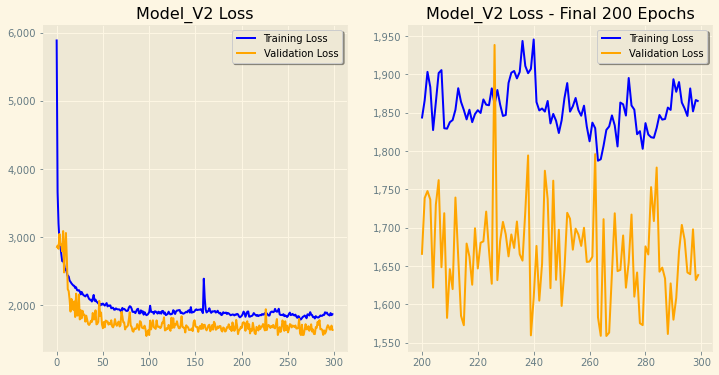

In [71]:
#Store training loss 
training_loss = pd.DataFrame()
training_loss['loss'] = history_v2.history['loss']
training_loss['val_loss'] = history_v2.history['val_loss']

#Create figure
f, ax = plt.subplots(1,2,figsize = (12,6))

#Plot training loss
training_loss.plot(ax=ax[0], color = ['blue','orange'])
training_loss[200:300].plot(ax=ax[1], color = ['blue','orange'])

#Set plot aesthetics
ax[0].set_title('Model_V2 Loss')
ax[0].legend(['Training Loss','Validation Loss'], frameon = True, shadow = True)
ax[0].get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

#Set plot aesthetics
ax[1].set_title('Model_V2 Loss - Final 200 Epochs')
ax[1].legend(['Training Loss','Validation Loss'], frameon = True, shadow = True)
ax[1].get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

#Save figure
plt.savefig(viz_path + '/Model_Training_Loss_V2.png',bbox_inches='tight')

**Save/Load Trained Base Model**

In [51]:
#Set path to save/load trained model
path = r'C:\Users\kishe\Documents\Data Science\Projects\Python Projects\In Progress\Airbnb - San Francisco Listings Analysis\Project_Codes\04_Modeling\Saved_Models'

#Save Trained model
tf.keras.models.save_model(model = model_v2, filepath = path + '/ANN_V2_Regressor')

# #Load saved model
# model_v1 = tf.keras.models.load_model(filepath = path + '/ANN_V2_Regressor')

#Print model summary
print('V1 ANN Summary:\n', model_v1.summary())

INFO:tensorflow:Assets written to: C:\Users\kishe\Documents\Data Science\Projects\Python Projects\In Progress\Airbnb - San Francisco Listings Analysis\Project_Codes\04_Modeling\Saved_Models/ANN_V2_Regressor\assets
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 79)                6320      
_________________________________________________________________
dropout (Dropout)            (None, 79)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               10240     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
________________________________________

**Evaluate base model on test data**

In [67]:
#Get predictions
v2_predictions = model_v2.predict(X_test_transformed, batch_size = 100)

In [68]:
#Store predictions, actual, and error
v2_results = pd.DataFrame(v2_predictions, columns=['predictions'])
v2_results['actual']=y_test
v2_results['error'] = v2_results['predictions'] - v2_results['actual']

#Evaluate Results
v2_metrics = regression_metrics('ANN Model V2', v2_predictions, y_test)

ANN Model V2 Evaluation Metrics:
R2: 0.7886904807435471
MAE: 30.17845471497554 
MSE: 12093.63826185793
RMSE: 109.97107920657108


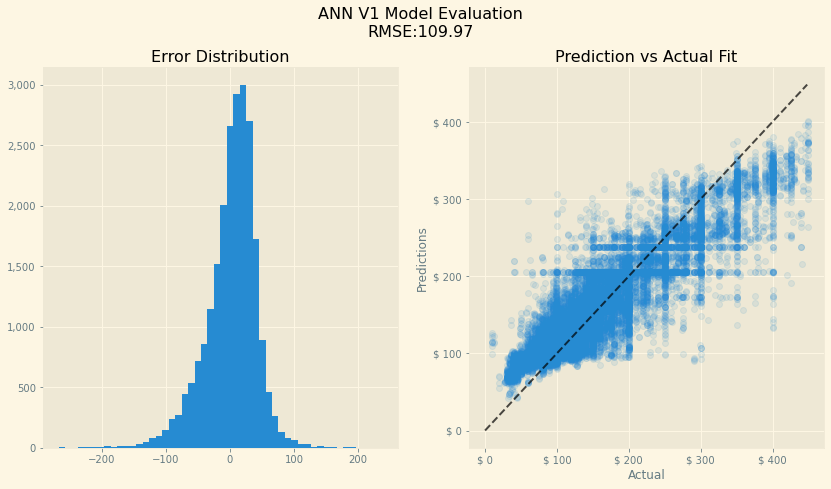

In [69]:
#Create figure
f, ax = plt.subplots(1,2,figsize = (14,7))

#Plot error distribution
v2_results.error.hist(ax = ax[0], bins = 50)

#PLot Predictions against Actual
ax[1].scatter(x = v2_results.actual, y = v2_results.predictions, alpha = .1)

#PLot best fit line
X=list(np.arange(0,max(v1_results.actual)))
ax[1].plot(X,X, color = 'black', linestyle = '--', alpha = .7)

#Set plot aesthetics
plt.suptitle('ANN V1 Model Evaluation\nRMSE:{}'.format(round(v2_metrics['rmse'],2)), y =1.0, fontsize = 16)
ax[0].set_title('Error Distribution')
ax[0].get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

ax[1].set_title('Prediction vs Actual Fit')
ax[1].set_xlabel('Actual')
ax[1].get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "$ {:}".format(int(x))))
ax[1].set_ylabel('Predictions')
ax[1].get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "$ {:}".format(int(x))))

#Save figure
plt.savefig(viz_path + '/ANNV2_Error_Evaluation.png',bbox_inches='tight')